<a href="https://colab.research.google.com/github/DanielCG19/DeepLearning-CC6204/blob/main/Tarea3/Copy_of_CC6204_Tarea_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de Células Sanguíneas

En el proceso de diagnóstico de enfermedades, el estudio de la cantidad de células sanguíneas juega un papel importante para determinar factores que explican una enfermedad. En esta tarea, la idea es implementar el modelo de deep-learning más efectivo posible para clasificar células sanguíneas. Las clases de células sanguíneas son: [Eosinophil, Lymphocyte, Monocyte, Neutrophil]


In [1]:
#Instalamos el paquete gdown para poder descargar el dataset desde el gdrive
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Descargamos el dataset
import gdown
output = 'blood.zip'
gdown.download(id='1CUQjT45tJmqNv_p2HcDkr4Z-IDQEbRg3', output=output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1CUQjT45tJmqNv_p2HcDkr4Z-IDQEbRg3
To: /content/blood.zip
100%|██████████| 105M/105M [00:00<00:00, 361MB/s] 


'blood.zip'

In [3]:
# Descomprimimos el dataset
!unzip blood.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/TRAIN/MONOCYTE/_0_4446.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4528.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_453.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4560.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4563.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4650.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4667.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4715.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4745.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4762.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4778.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4791.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4862.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4872.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4881.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4884.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4925.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_494.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_5029.jpeg  
 

Implementa la mejor red neuronal posible. Tú decides si usas una red creada por ti mismo o si empleas transfer-learning. Entrena la red con los datos en la carpeta "TRAIN" y usa los datos en "VAL" como validación.

Para medir el performance final, realiza las inferencias sobre los datos del conjunto "TEST" y computa el accuracy sobre el conjunto de test. El accuracy es la proporción de imágenes para las cuales la predicción es correcta. IMPORTANTE: el accuracy de test se calcula una sola vez cuando hayas finalizado todos tus experimentos. Para tomar decisiones sobre el modelo y sus hiperparámetros solo puedes usar el conjunto de entrenamiento y validación.

Detalla todos los experimentos que hiciste y cómo llegaste a la mejor red neuronal reportada. Discute los resultados, comparando los distintos experimentos que tomaste en cuenta y responde a la pregunta: Porqué tu modelo final fue el mejor de todo lo que probaste?

IMPORTANTE: Evita el overfitting a toda costa. Un modelo con overfitting es aquel que durante el entrenamiento las curvas de loss/accuracy para datos de entrenamiento y validación se separan considerablemente. 

Éxitos!

## Implementación
Dado el siguiente paper "Transfer learning with pre-trained deep convolutional neural networks for serous cell classification", se elige una red residual para hacer el transfer learning.

In [25]:
#librerias
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import time
import os
import copy
import sys
import copy

from torchvision.io import read_image
from PIL import Image
from sklearn.metrics import confusion_matrix
from time import perf_counter

import seaborn as sn
from sklearn.metrics import accuracy_score

torch.manual_seed(7)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Data loaders

In [43]:
#transformers 
data_transforms = {
    'TRAIN':
    transforms.Compose([
        transforms.Resize(size=(224,224)), 
        transforms.ToTensor(),
        transforms.Normalize([0.6788, 0.6414, 0.6606], [0.2580, 0.2576, 0.2550]), 
        ]),
      
    'TRAIN_AUG': 
    transforms.Compose([
          transforms.ColorJitter(),
          transforms.RandomHorizontalFlip(),
          transforms.RandomRotation(10),
          transforms.Resize(size=(224,224)),
          transforms.ToTensor(),
          transforms.Normalize([0.6788, 0.6414, 0.6606], [0.2580, 0.2576, 0.2550]),
      ]),

    'VAL':
    transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        ]),

    'TEST':
    transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        ]),
     }

In [44]:
# creating Location of data: train, validation, test
data='./images/'
batch_size = 32

train_path=os.path.join(data,'TRAIN')
valid_path=os.path.join(data,'VAL')
test_path=os.path.join(data,'TEST')


In [33]:
# creating Datasets to each of  folder created in prev
train_file=datasets.ImageFolder(train_path,transform=data_transforms['TRAIN'])
trainAug_file = datasets.ImageFolder(train_path,transform=data_transforms['TRAIN_AUG'])
valid_file=datasets.ImageFolder(valid_path,transform=data_transforms['VAL'])
test_file=datasets.ImageFolder(test_path,transform=data_transforms['TEST'])


#Creating loaders for the dataset
dataloaders={
    'train':torch.utils.data.DataLoader(train_file,batch_size,shuffle=True),
    'train_aug': torch.utils.data.DataLoader(train_file,batch_size,shuffle = True),
    'val':torch.utils.data.DataLoader(valid_file,batch_size,shuffle=True),
    'test': torch.utils.data.DataLoader(test_file,batch_size,shuffle=True)
}

In [37]:
def norm_std(dataloader):
  mean = 0.
  std = 0.
  nb_samples = 0.
  for data,y in dataloader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

  mean /= nb_samples
  std /= nb_samples
  return mean,std

In [45]:
mean,std = norm_std(dataloaders['train'])
print(mean)
print(std)

tensor([0.6788, 0.6414, 0.6606])
tensor([0.2580, 0.2576, 0.2550])


In [ ]:
class MyDataset(Dataset):
    def __init__(self,data):
        self.data = data
        
    def __getitem__(self, index):
        x = self.data[index]
        return x

    def __len__(self):
        return len(self.data)
    

dataset = MyDataset()
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    num_workers=1,
    shuffle=False
)




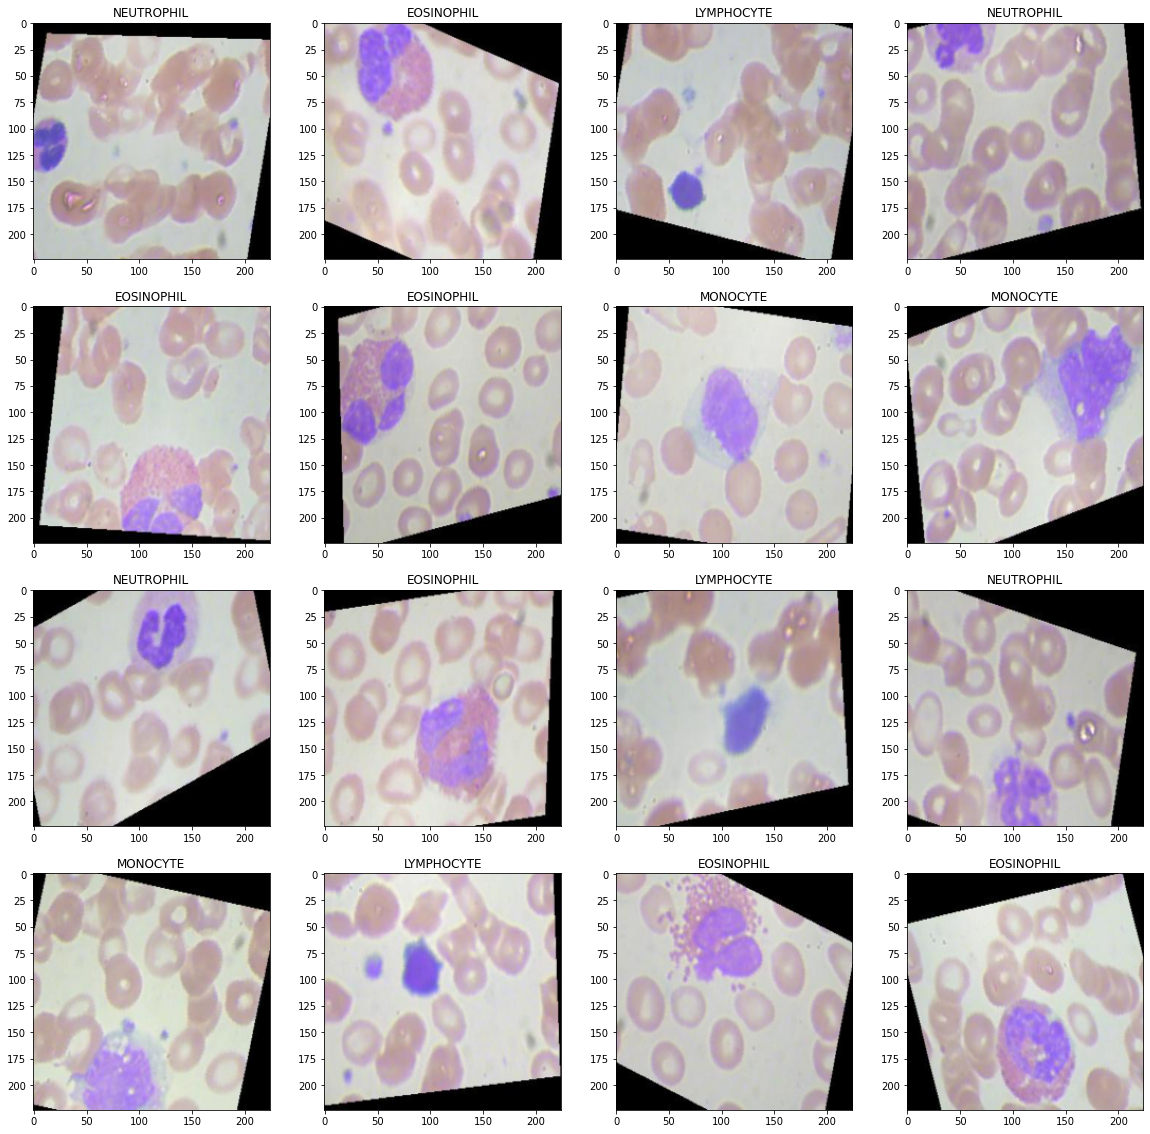

In [8]:
# Se ven algunas imágenes que se utilizan en entrenamiento.
# Se utiliza una adaptación de una función encontrada en página: https://www.guru99.com/transfer-learning.html

images, labels = next(iter(dataloaders['train']))
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
rows = 4
columns = 4
fig=plt.figure(figsize=(20,20))
for i in range(16):
   fig.add_subplot(rows, columns, i+1)
   plt.title(train_file.classes[labels[i]])
   img = images[i].numpy().transpose((1, 2, 0))
   img = std * img + mean
   plt.imshow(img)
plt.show()

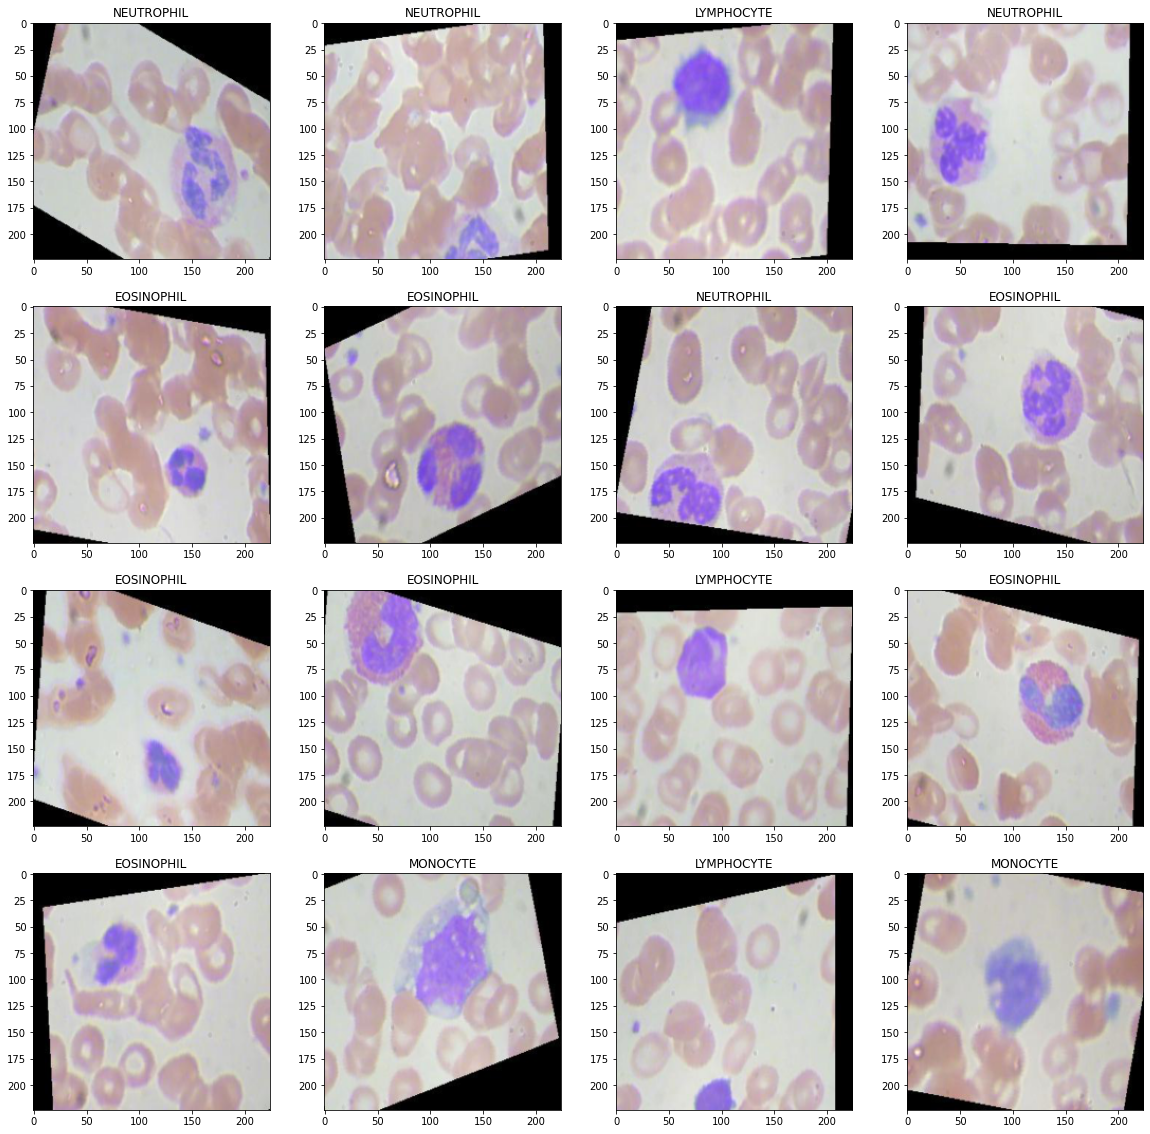

In [9]:
images, labels = next(iter(dataloaders['train_aug']))
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
rows = 4
columns = 4
fig=plt.figure(figsize=(20,20))
for i in range(16):
   fig.add_subplot(rows, columns, i+1)
   plt.title(train_file.classes[labels[i]])
   img = images[i].numpy().transpose((1, 2, 0))
   img = std * img + mean
   plt.imshow(img)
plt.show()

### Funciones


In [10]:
#Para evitar el overfitting, dado una tolerancia en épocas.
def earlyStop(train_loss, valid_loss, train_loss_epoch, valid_loss_epoch, patience):
  ntrain = len(train_loss_epoch)
  nvalid = len(valid_loss_epoch)
  average_train = 0
  average_valid = 0
  counter = 0

  if ntrain < patience:
    average_train = np.average(train_loss_epoch)
    average_valid = np.average(valid_loss_epoch)

  if ntrain >= patience:
    ntrain -= 1
    nvalid -= 1
    while counter != patience:
      average_train += train_loss_epoch[ntrain]
      average_valid += valid_loss_epoch[nvalid]
      ntrain -= 1
      nvalid -= 1
      counter +=1
    average_train = average_train/(patience)
    average_valid = average_valid/(patience)
  
  if (train_loss <= average_train) and (valid_loss > average_valid):  # detener, guardar checkpoint
    return True

  else: return False

In [19]:
def train_model2(num_epoch, model, dataloader, batchsize, dataaugmentation, criterion, optimizer, filepath, avg, n_save):
  global device

  train_losses = []       # to track the training loss as the model trains
  valid_losses = []       # to track the validation loss as the model trains
  
  avg_train_losses = []   # to track the average training loss per epoch as the model trains
  avg_valid_losses = []   # to track the average validation loss per epoch as the model trains

  if dataaugmentation == False:
    dataloader_val = dataloader['val'] 
    dataloader_train = dataloader['train'] 
  else:
    dataloader_val = dataloader['val']
    dataloader_train = dataloader['train_aug']

  for epoch in range(num_epoch):
      #if dataaugmentation == True:
      #  dataloader_val = dataloader['val']
      #  dataloader_train = dataloader['train_aug']
      try:
        model.train()

        # Train on the current epoch
        for x_train, y_train in dataloader_train:
            inputs = x_train.to(device)
            labels = y_train.to(device).long()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs, labels).cuda()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Compute validation loss and accuracy for current epoch
        model.eval()
        with torch.no_grad():  
          for x_val, y_val in dataloader_val:
              inputs = x_val.to(device)
              labels = y_val.to(device).long()

              outputs = model(inputs)
              # Calcular loss de validación
              loss = criterion(outputs, labels).cuda()
              # record validation loss
              valid_losses.append(loss.item())

        # No se debe guardar checkpoints en cada época (guardarlos cada 50 épocas)
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        # limpiar listas para la proxima epoca:
        train_losses = []
        valid_losses = []

        # imprimir resultados por epoca:  
        sys.stdout.write(f"\rÉpoca: {epoch} Training Loss: {train_loss} Validation Loss: {valid_loss}")

        stop = earlyStop(train_loss, valid_loss, avg_train_losses, avg_valid_losses, avg)
        
        if  stop == True:  # caso en que hay que deterner
            # cargar checkpoint, o guardar
            print(" - Early stopping")
            break

        # condición de checkpoint:
        if (epoch % n_save) == 0:
          torch.save(model.state_dict(), filepath)     
      
      # Interrupt Training
      except KeyboardInterrupt:
        print("\nEntrenamiento interrumpido")
        break

  # load the last checkpoint with the best model
  model.load_state_dict(torch.load(filepath))

  print('\nEntrenamiento finalizado')
  return model, avg_train_losses, avg_valid_losses

In [12]:
def predict(model, dataloader, plot_title):
  global device
  label_real = []
  pred_model = []
  model.eval()
  with torch.no_grad():
    for x,y in enumerate(dataloader, 0):
      inputs = x.to(device)
      labels = y.to(device)#.long()

      outputs= model(inputs)
      print(f"prediccion: {outputs}")
      pred = torch.argmax(outputs, 1)

      label_real = np.concatenate((label_real, labels.cpu().numpy()), axis=None)
      pred_model = np.concatenate((pred_model, pred.cpu().numpy()), axis=None)
      print(f"real: {label_real[0]}")
      print(f"pred: {pred_model[0]}")
      print(len(label_real), len(pred_model))

      
  print(label_real)
  print(pred_model)
      
  CM = confusion_matrix(label_real, pred_model, normalize= 'true')
  plt.figure(figsize = (10,7))
  sn.heatmap(CM, annot=True)
  plt.xlabel("Predicción")
  plt.ylabel("Observación")
  plt.title(plot_title)

  accuracy = accuracy_score(label_real, pred_model, normalize=True)
  print(f'accuracy: {accuracy}')
  return accuracy

In [13]:
def accuracy(y_pred, y_real):
  valor, posicion = torch.max(y_pred, dim = 1)
  pred = (posicion == y_real).float()
  accuracy = pred.sum()/len(pred)
  return accuracy

#### Gráficos

In [14]:
def plot(validation,train, plot_title):
  #minposs = validation.index(min(validation))+1 
  #plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')  # sirve para ver más o menos donde se tiene que detener
  #plt.title('Curva Loss - Epoch')
  plt.figure(figsize = (10,7))
  plt.plot(train, label='Train Loss')
  plt.plot(validation, label='Validation Loss')
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(plot_title)

In [15]:
def curvas_loss(early_epoca, perdidas_train, perdidas_val):
  try:
    plt.plot([e for e in range(early_epoca+1)], perdidas_train, label='Entrenamiento')
    plt.plot([e for e in range(early_epoca+1)], perdidas_val, label='Validacion')
  except:
    plt.plot([e for e in range(early_epoca)], perdidas_train, label='Entrenamiento')
    plt.plot([e for e in range(early_epoca)], perdidas_val, label='Validacion')
  plt.xlabel('Epocas')
  plt.ylabel('Valor')
  plt.title(f'Perdidas de entrenamiento/validacion para el modelo')
  plt.legend()
  plt.show()

# Entrenar Modelo

In [16]:
model_ft = models.resnet18(pretrained=True)

## freeze the layers
for param in model_ft.parameters():
   param.requires_grad = False

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(train_file.classes))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [23]:
model_ft2 = copy.deepcopy(model_ft)

num_epochs = 1000
batch_size = 150
n_save = 5
avg = 10
data_augmentation = True
file_path = 'model_ft18.pth'

model_ft_trained = train_model2(num_epochs, model_ft, dataloaders, batch_size, data_augmentation, criterion, optimizer_ft, file_path, avg, n_save)

Época: 2 Training Loss: 0.6787694792907971 Validation Loss: 0.8545139034589132 - Early stopping

Entrenamiento finalizado


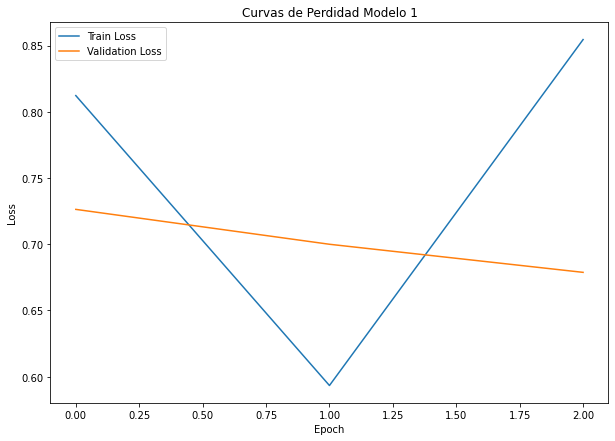

In [24]:
plot(model_ft_trained[1], model_ft_trained[2],'Curvas de Perdidad Modelo 1')